In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [2]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
analysis.ipynb	   baseline_5_ckpt	     multimodel_with_baseline_2
baseline	   baseline_ckpt	     multimodel_with_baseline_3
baseline_2	   baseline.ipynb	     my_net
baseline_2_ckpt    model.png		     my_net_ckpt
baseline_3	   multimodel_1		     my_net.ipynb
baseline_3_ckpt    multimodel_2		     simple
baseline_3_forSub  multi_model_2.ipynb	     simple_ckpt
baseline_4	   multi_model.ipynb	     smooth_with_fft.ipynb
baseline_4_ckpt    multimodel_model.ipynb    smooth_with_regression.ipynb
baseline_5	   multimodel_with_baseline  Training.csv


In [3]:
dataset = pd.read_csv('./Training.csv')

In [5]:
def chunk(x, size, stride):
  """
  divide the dataset in chunks. It keeps the right-most elements and discard the left ones, if size and stride are not
  compatible with dimensions
  """
  ret = []
  for i in range(len(x) - size, -1, -stride):
    ret.append(x[i: i + size])
  ret.reverse()
  return ret
  ## allignment is on the RIGHT

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 3
# stride = 2
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[2, 3, 4], [4, 5, 6], [6, 7, 8], [8, 9, 10]]

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 2
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[1, 2, 3, 4],[3, 4, 5, 6],[5, 6, 7, 8],[7, 8, 9, 10]]

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[1, 2, 3, 4],[4, 5, 6, 7],[7, 8, 9, 10]]

In [6]:
def rebuild(y, size, stride):
  """
  rebuild the original (if no cut were made) after the chunk function
  """
  s = size - stride
  ret = [0 for i in range(len(y[0]) * len(y) - (s * (len(y) - 1)))]

  for i in range(len(y[0])):
      ret[i] = y[0][i]

  ind = size
  for i in y[1:]:
    l = s
    for j in i:
      if l > 0:
        ret[ind - l] = (ret[ind - l] + j) / 2
      else:
        ret[ind - l] = j
      l -= 1
    ind += size - s
  return ret

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 2
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

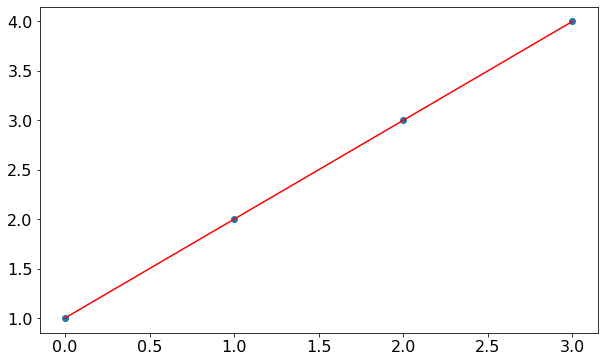

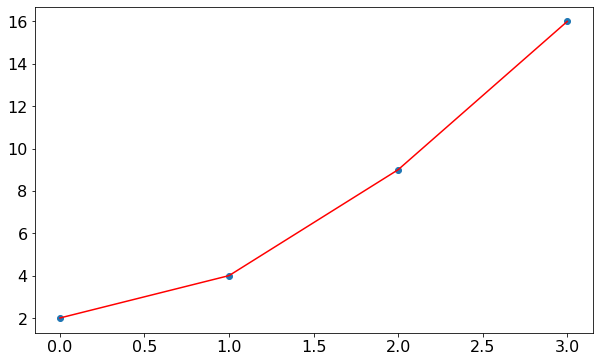

In [11]:
def getRegForChunk(chunk, degree, draw=False):
  """
  chunk: a 1D array of data
  degree: a single number, or a tuple. If it's a tuple it has to be (min_degree, max_degree), so that it looks for the best regression in that range
  draw: draws the generated regression
  """
  X = np.arange(len(chunk)).reshape(-1, 1)

  poly = PolynomialFeatures(degree=degree)
  poly_features = poly.fit_transform(X)
  poly_reg_model = linear_model.LinearRegression()
  poly_reg_model.fit(poly_features, chunk)
  y_predicted = poly_reg_model.predict(poly_features)
  
  if draw:
    plt.figure(figsize=(10, 6))
    plt.scatter(X, chunk)
    plt.plot(X, y_predicted, c='red')
    plt.show()
  
  return y_predicted

def allChunks(chunks, degree, draw=False):
  ret = []
  for c in chunks:
    ret.append(getRegForChunk(c, degree, draw))
  return ret

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# chunks = chunk(x, size, stride)
# y_pred = getRegForChunk(chunks[0], (1, 5), True)

# # test
# x = [2, 4, 9, 16, 25, 36, 49]
# size = 4
# stride = 3
# chunks = chunk(x, size, stride)
# y_pred = getRegForChunk(chunks[0], (1, 5), True)

In [20]:
def getRegression(x, size, stride, degree):
  y = chunk(x, size, stride)
  y = allChunks(y, degree)
  r = np.array(rebuild(y, size, stride))
  return r

we discarded  23 initial points


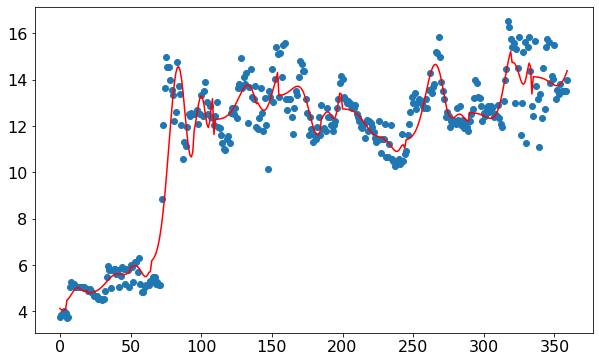

In [24]:
# # Test on hype root: keep size small, otherwise 
# x = dataset['Hype root']
# size = 60
# stride = 45
# degree = (6, 15)

# r = getRegression(x, size, stride, degree)

# discarded = len(x) - np.array(r).shape[0] 
# print("we discarded ", discarded, "initial points")

# # decide which data to visualize:
# inf = 40
# sup = 400

# x_ax = np.arange(sup - inf)
# plt.figure(figsize=(10, 6))
# plt.scatter(x_ax, x[inf + discarded:sup + discarded])
# plt.plot(x_ax, r[inf:sup], c='red')
# plt.show()

In [25]:
size = 60
stride = 45
degree = (6, 15)

In [26]:
new = {}
for i in dataset:
  new[i] = getRegression(dataset[i], size, stride, degree)

In [27]:
df = pd.DataFrame.from_dict(new)

In [28]:
print(df)

       Sponginess  Wonder level  ...  Soap slipperiness  Hype root
0        7.335393      5.597756  ...          35.672881   4.426402
1        7.335393      5.597756  ...          35.672881   4.426402
2        7.335393      5.597756  ...          35.672881   4.426402
3        7.335393      5.597756  ...          35.672881   4.426402
4        7.335393      5.597756  ...          35.672881   4.426402
...           ...           ...  ...                ...        ...
68500    6.815676      6.866006  ...          19.735387  15.097252
68501    6.627622      6.718196  ...          19.875841  12.712637
68502    6.342045      6.510553  ...          20.046488   7.959375
68503    6.326308      6.489667  ...          20.104337   5.401440
68504    7.518554      7.300105  ...          19.844516  17.218888

[68505 rows x 7 columns]


In [29]:
save = False
if save:
  df.to_csv('Training_smooth.csv', index=False)